In [154]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import kagglehub
import imghdr
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [141]:
# Download dataset
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)

Path to dataset files: /Users/wuyuhui/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [142]:
dataset_path = os.path.join(path, "asl_alphabet_train/asl_alphabet_train")
print(dataset_path)

/Users/wuyuhui/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train


In [143]:
# Custom Dataset Class
class ASLDataset(Dataset):
    def __init__(self, data_path, image_paths=None, labels=None, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        if image_paths is None or labels is None:
            self.classes = sorted(os.listdir(data_path))
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
            
            self.images = []
            self.labels = []
            
            for cls in self.classes:
                cls_path = os.path.join(data_path, cls)
                for img_name in os.listdir(cls_path):
                    img_path = os.path.join(cls_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[cls])
        else:
            self.images = image_paths
            self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = np.array(Image.open(img_path).convert("RGB"))  # Read the image as RGB
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [144]:
# Data transformations
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((64, 64)),
#     transforms.Grayscale(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])
# Updated Transformations to Keep RGB
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])

In [145]:
# Create full dataset
full_dataset = ASLDataset(dataset_path, transform=transform)

# Get classes and their mappings
classes = full_dataset.classes
class_to_idx = full_dataset.class_to_idx

# Split the data into training and validation sets
image_paths = full_dataset.images
labels = full_dataset.labels

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Create training and validation datasets
train_dataset = ASLDataset(
    data_path=dataset_path, 
    image_paths=train_image_paths, 
    labels=train_labels, 
    transform=transform
)
train_dataset.classes = classes  # Pass the classes to the training dataset
train_dataset.class_to_idx = class_to_idx  # Pass class-to-index mapping

val_dataset = ASLDataset(
    data_path=dataset_path,
    image_paths=val_image_paths,
    labels=val_labels,
    transform=transform
)
val_dataset.classes = classes  # Pass the classes to the validation dataset
val_dataset.class_to_idx = class_to_idx  # Pass class-to-index mapping

In [146]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [147]:
# Define the model
class ASLModel(nn.Module):
    def __init__(self, num_classes):
        super(ASLModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [148]:
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 8, 8]               0
          Flatten-10                 [-1, 8192]               0
           Linear-11                  [-1, 256]       2,097,408
             ReLU-12                  [-1, 256]               0
           Linear-13                   [-1, 29]           7,453
Total params: 2,198,109
Trainable param

In [149]:
# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = ASLModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [150]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Evaluate on validation set
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [151]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, criterion, epochs=10
)

Epoch 1/10
Train Loss: 0.4887, Train Accuracy: 84.56%
Val Loss: 0.1013, Val Accuracy: 96.49%
Epoch 2/10
Train Loss: 0.0588, Train Accuracy: 98.12%
Val Loss: 0.0634, Val Accuracy: 98.13%
Epoch 3/10
Train Loss: 0.0390, Train Accuracy: 98.80%
Val Loss: 0.0203, Val Accuracy: 99.34%
Epoch 4/10
Train Loss: 0.0274, Train Accuracy: 99.20%
Val Loss: 0.0699, Val Accuracy: 97.89%
Epoch 5/10
Train Loss: 0.0254, Train Accuracy: 99.25%
Val Loss: 0.0306, Val Accuracy: 99.01%
Epoch 6/10
Train Loss: 0.0196, Train Accuracy: 99.46%
Val Loss: 0.0049, Val Accuracy: 99.83%
Epoch 7/10
Train Loss: 0.0178, Train Accuracy: 99.51%
Val Loss: 0.0172, Val Accuracy: 99.47%
Epoch 8/10
Train Loss: 0.0144, Train Accuracy: 99.60%
Val Loss: 0.0424, Val Accuracy: 98.83%
Epoch 9/10
Train Loss: 0.0137, Train Accuracy: 99.65%
Val Loss: 0.0225, Val Accuracy: 99.49%
Epoch 10/10
Train Loss: 0.0151, Train Accuracy: 99.62%
Val Loss: 0.0122, Val Accuracy: 99.67%


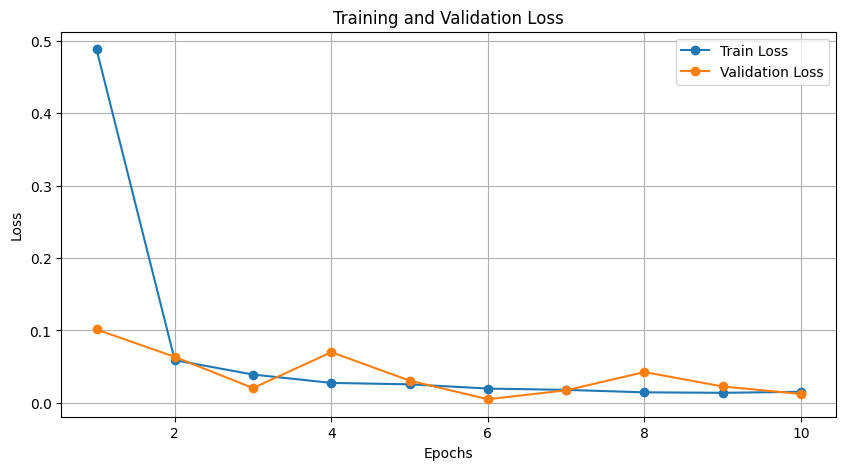

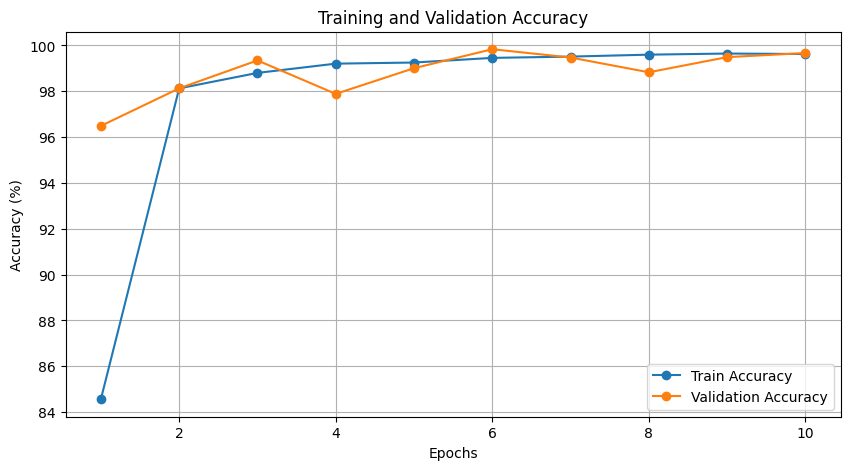

In [160]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('img/CNN_loss')
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.savefig('img/CNN_acc')
plt.show()

In [177]:
def evaluate_confusion_matrix(model, loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    # Collect all true labels and predictions
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

    # Plot confusion matrix with larger size and smaller text
    fig, ax = plt.subplots(figsize=(15, 15))  # Increase figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    
    # Adjust font size of labels
    ax.tick_params(axis='both', which='major', labelsize=10)  # Make text smaller
    plt.title("Confusion Matrix", fontsize=16)  # Adjust title font size
    plt.savefig('img/CNN_cm')
    plt.show()

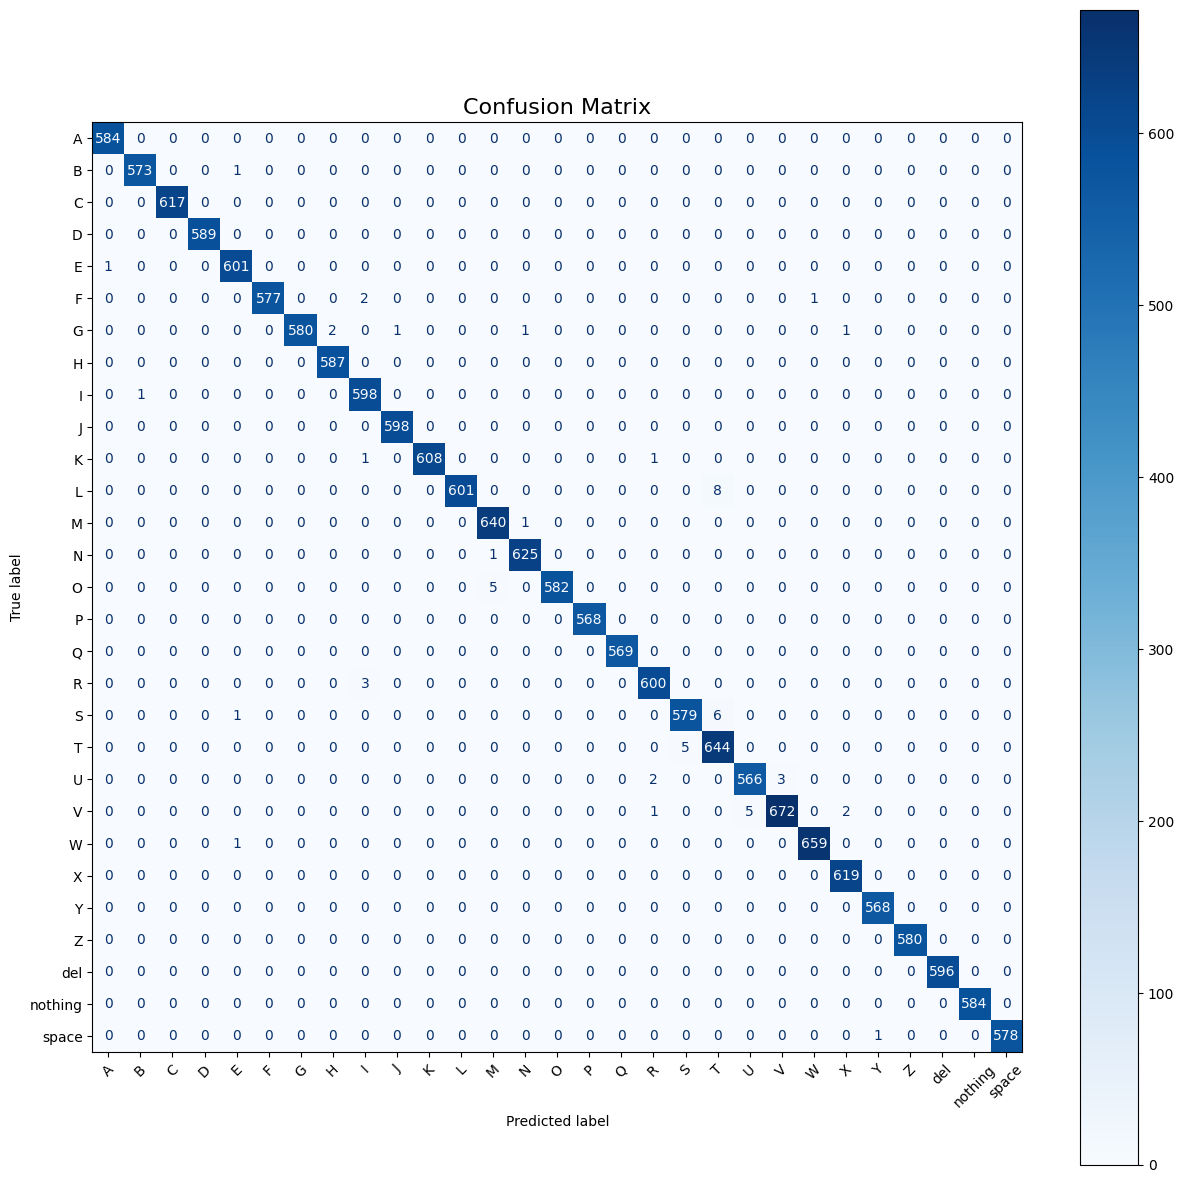

In [178]:
class_names = train_dataset.classes 
evaluate_confusion_matrix(model, val_loader, class_names)

In [161]:
dataset_test_path = os.path.join(path, "asl_alphabet_test/asl_alphabet_test")
print(dataset_test_path)

/Users/wuyuhui/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_test/asl_alphabet_test


In [170]:
transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [171]:
class TestDataset(Dataset):
    def __init__(self, test_path, transform=None):
        """
        Args:
            test_path (str): Path to the folder containing test images.
            transform (callable, optional): Optional transforms to apply to the images.
        """
        self.test_path = test_path
        self.transform = transform_test
        self.images = []
        self.labels = []
        
        # Extract image paths and labels from filenames
        for file_name in os.listdir(test_path):
            if file_name.endswith(".jpg"):  # Ensure it's an image file
                self.images.append(os.path.join(test_path, file_name))
                # Extract label from the filename (e.g., "A_test.jpg" -> "A")
                self.labels.append(file_name.split("_")[0])

        # Create a mapping for labels to numerical indices
        self.classes = sorted(set(self.labels))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.labels = [self.class_to_idx[label] for label in self.labels]
    
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [179]:
def evaluate_test_set(model, test_loader, class_names):
    """
    Evaluate the model on the test set and display the confusion matrix.
    
    Args:
        model: Trained model.
        test_loader: DataLoader for the test set.
        class_names: List of class names.
    """
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Compute and plot the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(15, 15))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.title("Confusion Matrix (Test Set)", fontsize=16)
    plt.savefig('img/CNN_testset')
    plt.show()

In [173]:
# Create test dataset and DataLoader
test_dataset = TestDataset(dataset_test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = test_dataset.classes
print("Classes:", class_names)

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


Test Accuracy: 92.86%


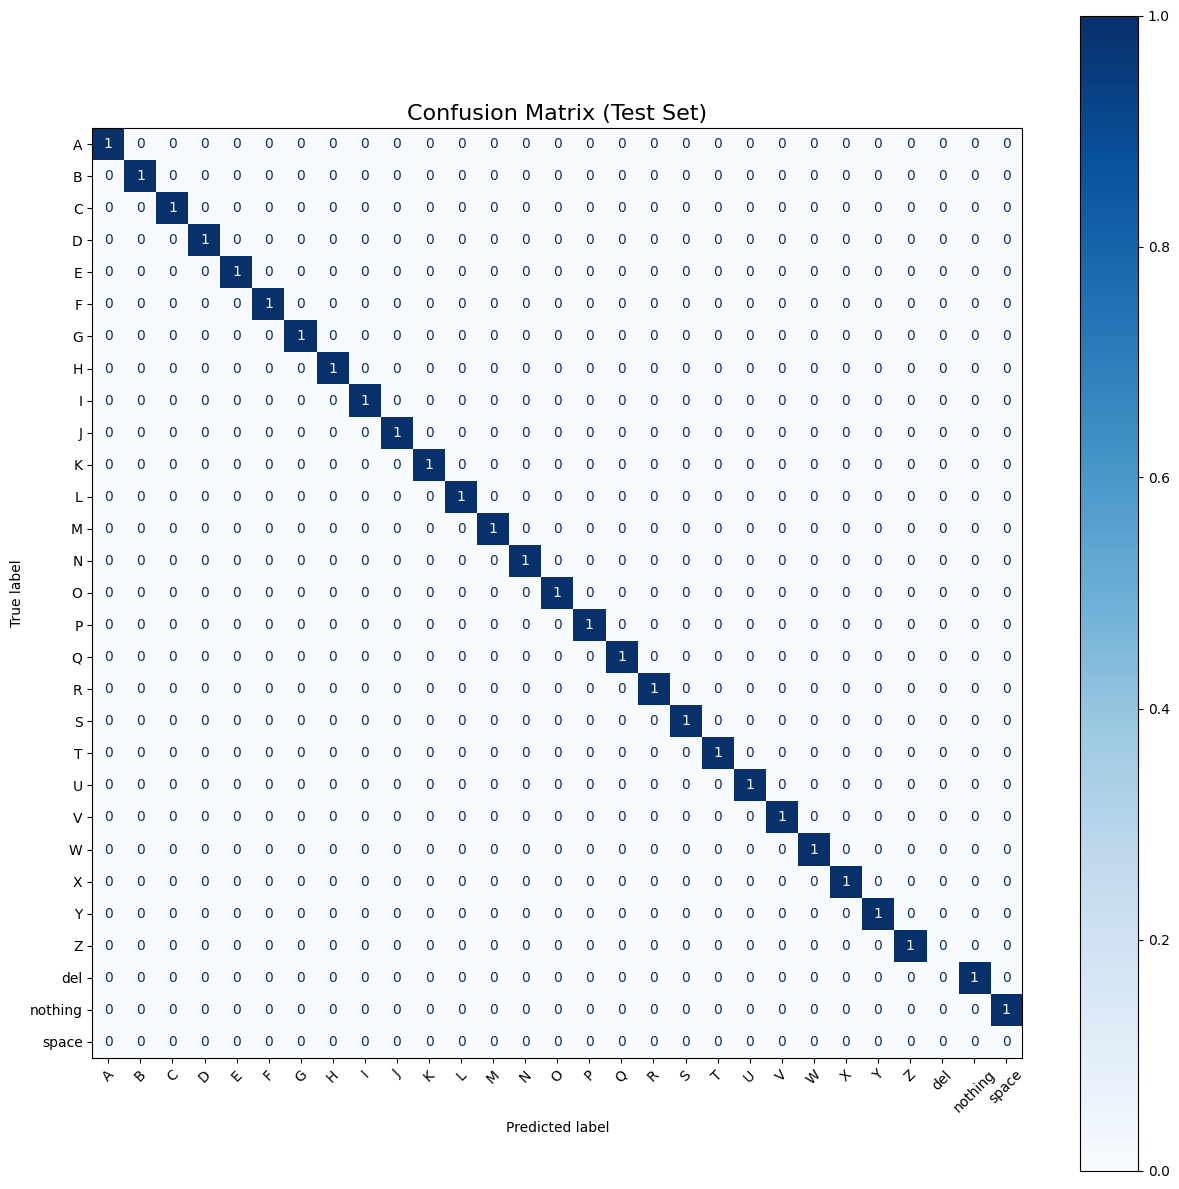

In [180]:
# Evaluate on test set
evaluate_test_set(model, test_loader, class_names)